In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from analyser import Analyser
from db import SqliteDb as db

# Documentation

## Research Questions

** Which contribution have bots to the quality of Wikidata? **
* Which differences exist between bots which successfully completed the request for permission process and those who doesn't? (Hypothesis: The request for permission process is a quality gate for bots)
* How does bot's field of activity change over time?
* What is the difference between a bot with the group 'bot' and a bot with a botflag?


## Data preparation
### Request for permissions

As a first step we downloaded and parsed the data about requests for permissions for bots from Wikidata in May 2018. We collected the already closed requests which can be found in the Wikidata archive (https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Archive#Requests_for_bot_flags). The data is stored in a database.

Request for permissions which have no own page were left out (e.g. https://www.wikidata.org/w/index.php?title=Wikidata:Requests_for_permissions/Bot/Checkallthestrings_bot_1&action=edit&redlink=1).

Request for permissions which are listed several times in different archives were only parsed once (e.g. https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Bot/VIAFbot is listes in https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/March_2013 and in https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/April_2013).

## DB

### Schema

The db in which the requests for permissions are saved has the following schema as diagram:

![DB schema](images/db_schema.png)

and as ddl: 

```sql
CREATE TABLE request_for_permission (
    id                    INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    url                   TEXT UNIQUE,
    bot                   TEXT,
    operator              TEXT,
    is_successful         INTEGER,
    first_edit            TEXT,
    last_edit             TEXT,
    closed_at             TEXT,
    revision_count        INTEGER,
    editor_count          INTEGER,
    comment_symbol_count  INTEGER,
    question_symbol_count INTEGER,
    oppose_symbol_count   INTEGER,
    answer_symbol_count   INTEGER,
    support_symbol_count  INTEGER,
    html                  TEXT,
    task                  TEXT,
    code                  TEXT,
    function              TEXT,
    archive_comment       TEXT,
    summary               TEXT,
    retrieved_at          DATE,
    FOREIGN KEY(operator) REFERENCES operator(name)
);
CREATE TABLE bot (
    name TEXT PRIMARY KEY NOT NULL
);
```

### Tables

The db fields for the tabel request_for_permission contains the following content:

| column                | content explanation                                                                   |
| ----------------------|:-------------------------------------------------------------------------------------:|
| id                    | unique identifier                                                                     |
| url                   | url of the request for permission                                                     |
| bot                   | the wikidata user account for which the request for permission is for.                |
| operator              | the wikidata user account which opend the request for permission and is responsible for the bot. |
| is_successful         | flag which states if the request for permission was successful. 1 if it was successful and 0 if not     |
| first_edit            | utc date and time when the first edit of this request for permission was made         |
| last_edit             | utc date and time when the last edit of this request for permission was made          |
| closed_at             | utc date and time when the request for permission was closed which is equvalent to the time when the summary was written |
| revision_count        | count how many revisions were applied to the request for permission                   |
| edit_count            | count how many distinct editors made revisons to the request for permission           |
| comment_symbol_count  | count how often a comment symbol was used in the discussion of the request            |
| question_symbol_count | count how often a question symbol was used in the discussion of the request           |
| oppose_symbol_count   | count how often a oppose symbol was used in the discussion of the request             |
| answer_symbol_count   | count how often a answer symbol was used in the discussion of the request             |
| support_symbol_count  | count how often a support symbol was used in the discussion of the request            |
| html                  | raw html of the site that can be found under the url. only the main part of the site is saved. |
| task                  | short description of the bot function                                                 |
| code                  | link to the online repository or other code describing text                           |
| function              | detailed description of the bot function                                              |
| archive_comment       | short comment why the request for permission was successful or not. Example can be found under the following link: https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/RfBot/April_2013 (see for example '(approved temporary)') |
| summary               | summary about the discussion and the final decision about the request for permission   | 
| retrieved_at          | utc date and time when the data was retrived                                          |

The db fields for the tabel bot contains the following content:

| column                | content explanation                                                                   |
| ----------------------|:-------------------------------------------------------------------------------------:|
| name                  | name of the bot                                                                       |


## Analysis

### Analysis of Wikidata Bots

This chapter aims to analyse the bots on wikidata. 

As a first step we try to find out which user accounts on Wikidata are bots. There are several sources that contain lists of bots or can help to detect them. None of them is complete. Therefore we fetched data from five different sources. The following table lists these sources and the number of contained bots.

Note: The list is updateed manually thus disparities between this tables and the following results may occur! Last update: 28 May 2018

| criteria                           | amount       | source               | output file          |
| ---------------------------------- |:------------:|:--------------------:|:--------------------:|
| number of users in the group 'bot' | 245 | MediaWiki API (Example URL: https://www.wikidata.org/w/api.php?action=query&list=allusers&augroup=bot) | data/parser/users_in_bot_group.csv |
| number of bots that have a closed request for permission | 364 | [Requests for bot flags](https://www.wikidata.org/wiki/Wikidata:Requests_for_permissions/Archive#Requests_for_bot_flags ) | data/spiders/bots_with_requests_for_permissions.csv |
| number of bots with a botflag     | 258 | [Bots with botflag](https://www.wikidata.org/wiki/Category:Bots_with_botflag) | data/spiders/bots_with_botflag.csv |
| number of bots without a botflag  | 163 | [Bots without a botflag](https://www.wikidata.org/wiki/Category:Bots_without_botflag) | data/spiders/bots_without_botflag.csv |
| number of extension bots           | 7 | [Extension bots](https://www.wikidata.org/wiki/Category:Extension_bots) | data/spiders/extension_bots.csv |

The following statistics describe partially the same as the table before but instead of fetching the results from the csv files there are retrived from the db. If you want to see not only the count but the name of the bots you can uncomment the line ```python # print(bots) ``` and you will see all names.

In [2]:
conn = db.connect()
cursor = conn.cursor()

In [3]:
index = ['b_f', 'no_b_f', 'ex_b', 'group', 'request', 's_request', 'u_request', 'sum']
df = pd.DataFrame(index=index, columns=index)

The following describes the number and names of bots with a botflag.

In [4]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE has_botflag = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['b_f']['b_f'] = len(bots)
# print(bots)

The following describes the number names of bots without a botflag

In [5]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE has_botflag = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['no_b_f']['no_b_f'] = len(bots)
# print(bots)

The following describes the number and names of extension bots 

In [6]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE is_extension_bot = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['ex_b']['ex_b'] = len(bots)
# print(bots)

The following describes the number and names of bots with the group 'bot'

In [7]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%'"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['group']['group'] = len(bots)
# print(bots)

The following describes the number and names of bots with a request for permission

In [8]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['request'] = len(bots)
# print(bots)

The following describes the number and names of bots with a successful request for permission

In [9]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions WHERE is_successful = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['s_request']['s_request'] = len(bots)
df['s_request']['request'] = len(bots)
# print(bots)

The following describes the number and names of bots with an unsuccessful request for permission

In [10]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions WHERE is_successful = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['u_request'] = len(bots)
df['u_request']['request'] = len(bots)
# print(bots)

The following describes the number and names of bots with a bot flag and without a bot flag

In [11]:
df['no_b_f']['b_f'] = 0

The following describes the number and names of bots with a bot flag and is a extension bot

In [12]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE bots.has_botflag = 1 AND bots.is_extension_bot = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['ex_b']['b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots with a bot flag and in group 'bot'

In [13]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%' AND has_botflag = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['group']['b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots with a bot flag and a request for permission

In [14]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['request']['b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots with a bot flag and a successful request for permission

In [15]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 1 AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['s_request']['b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots with a bot flag and an unsuccessful request for permission

In [16]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 1 AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['u_request']['b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots without a bot flag and is a extension bot

In [17]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE bots.has_botflag = 0 AND bots.is_extension_bot = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['ex_b']['no_b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots without a bot flag and in group 'bot'

In [18]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%' AND has_botflag = 0"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['group']['no_b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots without a bot flag and a request for permission

In [19]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['no_b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots without a bot flag and a successful request for permission

In [20]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 0 AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['s_request']['no_b_f'] = len(bots)
# print(bots)

The following describes the number and names of bots without a bot flag and an unsuccessful request for permission

In [21]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE bots.has_botflag = 0 AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['no_b_f'] = len(bots)
# print(bots)

The following describes the number and names of extension bots and in group 'bot'

In [22]:
sql = "SELECT DISTINCT(bots.name) FROM bots WHERE groups LIKE '%bot%'AND is_extension_bot = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['group']['ex_b'] = len(bots)
# print(bots)

The following describes the number and names of extension bots and a request for permission

In [23]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE is_extension_bot = 1"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['ex_b'] = len(bots)
# print(bots)

The following describes the number and names of extension bots and a successful request for permission

In [24]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE is_extension_bot = 1 AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['s_request']['ex_b'] = len(bots)
# print(bots)

The following describes the number and names of extension bots and an unsuccessful request for permission

In [25]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE is_extension_bot = 1 AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['u_request']['ex_b'] = len(bots)
# print(bots)

The following describes the number and names of bots in group 'bot' and a request for permission

In [26]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE groups LIKE '%bot%'"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['request']['group'] = len(bots)
# print(bots)

The following describes the number and names of bots in group 'bot' and a successful request for permission

In [27]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE groups LIKE '%bot%' AND requests_for_permissions.is_successful = 1"
result = cursor.execute(sql)

bots = []
for item in result:
    bots.append(item[0])
df['s_request']['group'] = len(bots)
# print(bots)

The following describes the number and names of bots in group 'bot' and an unsuccessful request for permission

In [28]:
sql = "SELECT DISTINCT(bots.name) FROM bots INNER JOIN requests_for_permissions ON requests_for_permissions.bot_name = bots.name WHERE groups LIKE '%bot%' AND requests_for_permissions.is_successful = 0"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['group'] = len(bots)
# print(bots)

The following describes the number and of bots with a successful an unsuccessful request for permission

In [29]:
sql = "SELECT DISTINCT(bot_name) FROM requests_for_permissions WHERE  requests_for_permissions.is_successful = 1 AND bot_name IN (SELECT bot_name FROM requests_for_permissions WHERE requests_for_permissions.is_successful = 0)"
result = cursor.execute(sql)
    
bots = []
for item in result:
    bots.append(item[0])
df['u_request']['s_request'] = len(bots)
# print(bots)

The subsequent table summarizes all previous calculated values (only the count) to give a better overview. The collumn names are described as follows:

| column name               | explanation                               |
| --------------------------|:-----------------------------------------:|
| b_f                       | has bot flag                              |
| no_b_f                    | has no bot flag                           |
| ex_b                      | is a extension bot                        |
| group                     | is in group 'bot'                         |
| request                   | has a request for permission              |
| s_request                 | has a successful request for permission   |
| u_request                 | has a unsuccessful request for permission |

In [30]:
print(df)

           b_f no_b_f ex_b group request s_request u_request  sum
b_f        258      0    0   200     244       244        20  NaN
no_b_f     NaN    161    0    23      61        40        23  NaN
ex_b       NaN    NaN    6     3       1         1         0  NaN
group      NaN    NaN  NaN   251     237       237        15  NaN
request    NaN    NaN  NaN   NaN     367       321        70  NaN
s_request  NaN    NaN  NaN   NaN     NaN       321        24  NaN
u_request  NaN    NaN  NaN   NaN     NaN       NaN        70  NaN
sum        NaN    NaN  NaN   NaN     NaN       NaN       NaN  NaN


The following describes the number and the names of all unique bots. These bots are retrieved from all lists (e.g. bots with a bot flag, bots without a bot flag, bots with a request for permission, bots in the user group 'bot' and extension bots)

In [31]:
result = cursor.execute(
    '''
    SELECT name AS bot
    FROM bots
    UNION
    SELECT bot_name AS bot
    FROM requests_for_permissions
    ''')
    
bots = []
for item in result:
    bots.append(item[0])
bots = set(bots)

print("Number of all unique bots: %d" % len(bots))
print("Names of all unique bots: %s" % ', '.join(list(bots)))

Number of all unique bots: 489
Names of all unique bots: Fabot, PositionStatements Bot, Mr Robot, CyclingInitBot, Citing Bot, Antoine2711bot, SaschaBot, ThieolBot, Huzzlet the bot, JarektBot, Kartṛ-bot, DanmicholoBot, ValterVBot, 1VeertjeBot, Byrialbot, DynamicBot Srv2, Donna Nobot, Sartle.wiki.bot, MechQuesterBot, Kompakt-bot, Dom bot, Lingua Libre Bot, JonHaraldSøbyWMNO-bot, Glavkos bot, SDrewthbot, Krdbot, EmptyBot, JVbot, AlphamaBot, SvebertBot, PastoriBot, BacDiveBot, AxelBot, BacterialAnnotationBot, LinedBot, ZbwAddAuthorityBot, Lisp.hippie.bot, Framabot, CoBot, L PBot, US National Archives bot, The Anomebot, CommonsDelinquent, Addbot, Mbchbot, JhealdBatch, MahdiBot, Hkn-bot, Jane023bot, ViscoBot, RoboViolet, DiscogsBot, Peuc bot, ZaBOTka, BotMultichill, BraveBot, BotNinja, MalarzBOT, Alecs.bot, RobotMichiel1972, Github-wiki-bot, HaroldBot, PreferentialBot, RobotRobin, ScorumMEBot, TaxonBot, AvicBot, Eflybot, Choboty, Cyberbot I, Smbbot, Atobot, Johnflow, Butlerbot, LkastlerBot, 

The following section compares all unique bots which have a request for permission and all other bots.

The first comparison is the amount of bots with and without a request for permission and there names.

Bots with a request for permission:

In [32]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name)
    FROM requests_for_permissions
    ''')

bots = []
for item in result:
    bots.append(item[0])
bots = set(bots)

print("Number of all unique bots with a request for permission: %d" % len(bots))
print("Names of all unique bots with a request for permission: %s" % ', '.join(list(bots)))

Number of all unique bots with a request for permission: 367
Names of all unique bots with a request for permission: Fabot, PositionStatements Bot, CyclingInitBot, Citing Bot, SaschaBot, ThieolBot, ValterVBot, DanmicholoBot, Byrialbot, DynamicBot Srv2, Donna Nobot, Sartle.wiki.bot, MechQuesterBot, Kompakt-bot, Dom bot, Lingua Libre Bot, Glavkos bot, SDrewthbot, Krdbot, EmptyBot, SvebertBot, JVbot, AlphamaBot, BacDiveBot, Lisp.hippie.bot, Framabot, L PBot, CoBot, The Anomebot, Addbot, Mbchbot, JhealdBatch, MahdiBot, Hkn-bot, Jane023bot, ViscoBot, RoboViolet, DiscogsBot, Peuc bot, ZaBOTka, BotMultichill, BraveBot, BotNinja, RobotMichiel1972, MalarzBOT, Github-wiki-bot, PreferentialBot, HaroldBot, ScorumMEBot, TaxonBot, Choboty, Cyberbot I, Smbbot, Atobot, SergoBot, Mahirbot, ItalianSchoolsBot, RollBot, HaploBot, RfcBot, Shuaib-bot, AkBot, Botik, Epochs bot, DbBot, Shyde, ShonagonBot, MastiBot, Steenthbot, SourcererBot, Tulsibot, PokestarFanBot, Hoo Bot, MajedBot, PajnBot, Nicolas1981Bot,

Bots without a request for permission:

In [33]:
result = cursor.execute(
    '''
    SELECT name 
    FROM bots
    EXCEPT
    SELECT DISTINCT(bot_name) AS name
    FROM requests_for_permissions
    ''')

bots = []
for item in result:
    bots.append(item[0])
bots = set(bots)

print("Number of all unique bots without a request for permission: %d" % len(bots))
print("Names of all unique bots without a request for permission: %s" % ', '.join(list(bots)))

Number of all unique bots without a request for permission: 122
Names of all unique bots without a request for permission: BernsteinBot, DangSunBot, BinBot, Աշբոտ, Mr Robot, MediaWiki default, Gerakibot, YuatchaBot, AeroidBot, CultureBot, Antoine2711bot, NIOSH bot, Huzzlet the bot, JarektBot, Asahibot, Kartṛ-bot, UVbot, Politican scraper comparison bot, Lansbot, 1VeertjeBot, Gabrielchihonglee-Bot, JanitorBot, Manuvinabot, JonHaraldSøbyWMNO-bot, PavloChemBot, BOTZellforschung, Bovlbbot, Rebot, Zielmicha Bot, Soh.Miero.Bot, JohlBot, Babel AutoCreate, PastoriBot, AxelBot, BacterialAnnotationBot, LinedBot, Maintenance script, ZbwAddAuthorityBot, UreomicsBot, DimaBot, ÖdokBot, US National Archives bot, KoehlBot, YBot, Rodrigo Padula (BOT), CommonsDelinquent, FloBot, Ajrbot, SPQRobot, BotLuffyTech, DæghrefnBot, Persian Wikis Janitor Bot, Crossref bot, Bigbossrobot, Ping08Bot, DynBot Srv2, IDbot, BonifazWolbot, Arasaacbot, MenoBot, ThetaBot, WikiTrackBot, Alecs.bot, Mangler-bot, RobotRobin, U

The next comparison is the user rights of bots with and without a request for permission.

The following shows the destribution of rights of bots with a request for permission. Note: the rights could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that have a specific right is 350 and not 367!

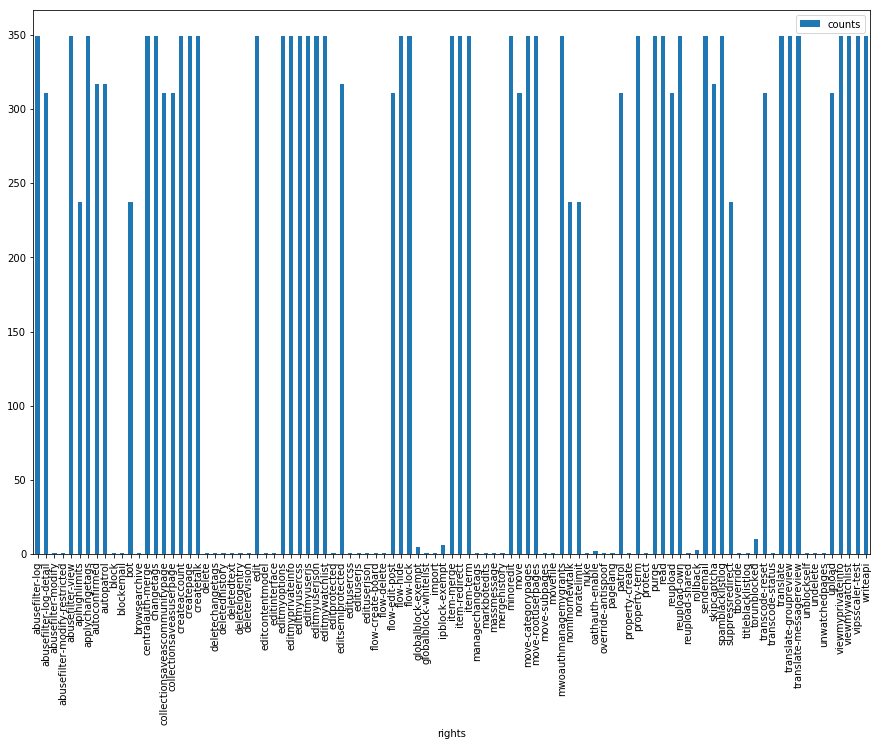

In [34]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), rights
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

rights_dict = {'rights': []}
for item in result:
    if item[1] is not None:
        rights_dict['rights'] += item[1].split(',')

df = pd.DataFrame(rights_dict)
df = df.groupby(['rights']).size().reset_index(name='counts')
df.plot(x='rights', y='counts', figsize=(15,10), kind='bar')

The following shows the destribution of rights of bots without a request for permission. Note: the rights could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that have a specific right is 120 and not 122!

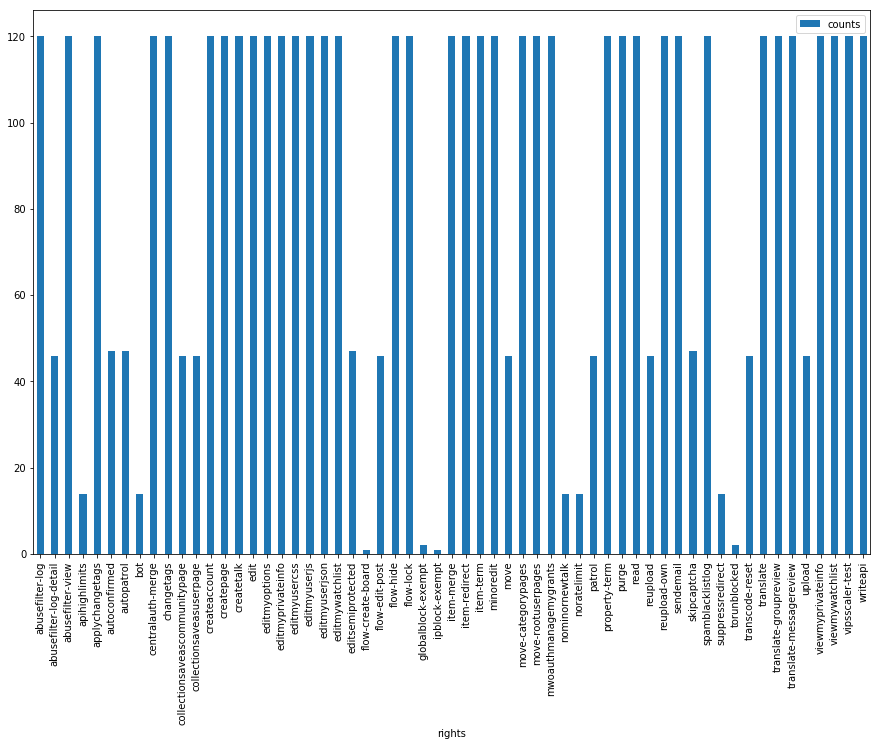

In [35]:
result = cursor.execute(
    '''
    SELECT rights
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

rights_dict = {'rights': []}
for item in result:
    if item[0] is not None:
        rights_dict['rights'] += item[0].split(',')

df = pd.DataFrame(rights_dict)
df = df.groupby(['rights']).size().reset_index(name='counts')
df.plot(x='rights', y='counts', figsize=(15,10), kind='bar')

In [36]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), rights
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

with_request_rights = []

for item in result:
    if item[1] is not None:
        with_request_rights += item[1].split(',')

with_request_rights = set(with_request_rights)

result = cursor.execute(
    '''
    SELECT rights
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

without_request_rights = []

for item in result:
    if item[0] is not None:
        without_request_rights += item[0].split(',')

without_request_rights = set(without_request_rights)

The following shows all right that bots with a request for permission have but all other bots do not have.

In [37]:
', '.join(with_request_rights.difference(without_request_rights))

'movefile, managechangetags, titleblacklistlog, transcode-status, unwatchedpages, blockemail, nuke, editusercss, edituserjson, tboverride, editprotected, edituserjs, deletedhistory, unblockself, editinterface, deleterevision, browsearchive, deletechangetags, deletedtext, import, delete, editcontentmodel, abusefilter-modify, pagelang, globalblock-whitelist, massmessage, reupload-shared, move-subpages, rollback, deletelogentry, abusefilter-modify-restricted, oathauth-enable, block, flow-delete, protect, mergehistory, undelete, property-create, override-antispoof, markbotedits'

The following shows all right that bots without a request for permission have but all other bots do not have.

In [38]:
', '.join(without_request_rights.difference(with_request_rights))

''

The next comparison is the user groups of bots with and without a request for permission.

The following shows the destribution of groups of bots with a request for permission. Note: the groups could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that are in a specific group is 350 and not 367!

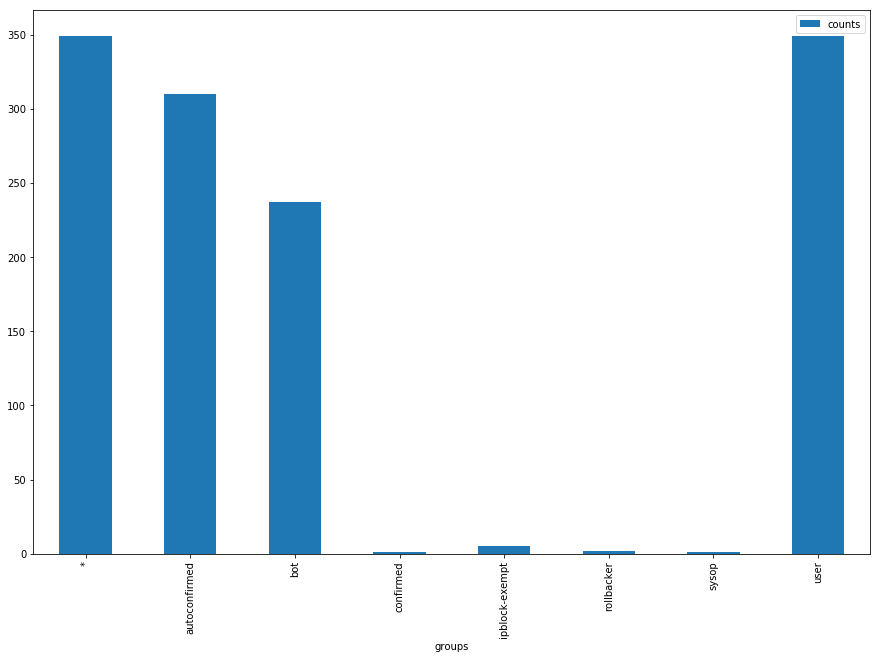

In [39]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), groups
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

groups_dict = {'groups': []}
for item in result:
    if item[1] is not None:
        groups_dict['groups'] += item[1].split(',')

df = pd.DataFrame(groups_dict)
df = df.groupby(['groups']).size().reset_index(name='counts')
df.plot(x='groups', y='counts', figsize=(15,10), kind='bar')

The following shows the destribution of groups of bots without a request for permission. Note: the groups could not be retrived for all bots form the API for the reason that some bots for example do not have a user account anymore. Therefore in the graphic the maximum value of bots that are in a specific group is 120 and not 122!

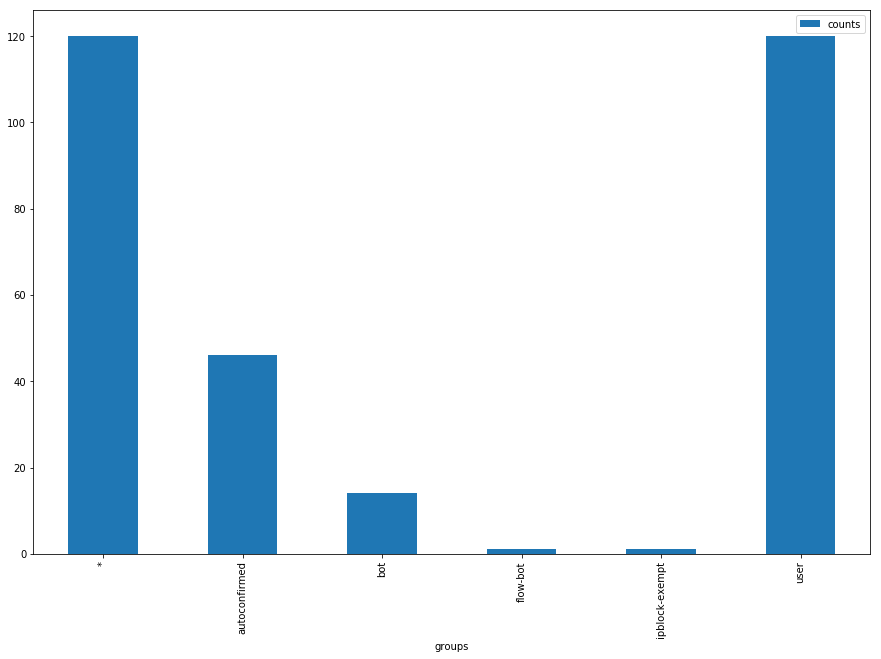

In [40]:
result = cursor.execute(
    '''
    SELECT groups
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

groups_dict = {'groups': []}
for item in result:
    if item[0] is not None:
        groups_dict['groups'] += item[0].split(',')

df = pd.DataFrame(groups_dict)
df = df.groupby(['groups']).size().reset_index(name='counts')
df.plot(x='groups', y='counts', figsize=(15,10), kind='bar')

In [41]:
result = cursor.execute(
    '''
    SELECT DISTINCT(bot_name), groups
    FROM requests_for_permissions
    INNER JOIN bots ON bots.name = requests_for_permissions.bot_name
    ''')

with_request_groups = []

for item in result:
    if item[1] is not None:
        with_request_groups += item[1].split(',')
        
with_request_groups = set(with_request_groups)

result = cursor.execute(
    '''
    SELECT groups
    FROM bots 
    WHERE name IN (
        SELECT name
        FROM bots
        EXCEPT
        SELECT DISTINCT(bot_name) AS name
        FROM requests_for_permissions
    )
    ''')

without_request_groups = []

for item in result:
    if item[0] is not None:
        without_request_groups += item[0].split(',')

without_request_groups = set(without_request_groups)

The following shows all groups that bots with a request for permission have but all other bots do not have.

In [42]:
', '.join(with_request_groups.difference(without_request_groups))

'sysop, confirmed, rollbacker'

The following shows all right that bots without a request for permission have but all other bots do not have.

In [43]:
', '.join(without_request_groups.difference(with_request_groups))

'flow-bot'

### Difference between rights of bots wist a bot flag and bots which are in the group 'bot'

The following shows which different rights bots with a bot flag but without beeing in the group 'bot' have.

In [44]:
sql = "SELECT rights FROM bots WHERE has_botflag = 1 AND groups NOT LIKE '%bot%'"
result = cursor.execute(sql)

bot_flag_rights = []
for item in result:
    if item[0] is not None:
        bot_flag_rights += item[0].split(',')
bot_flag_rights = set(bot_flag_rights)
print(bot_flag_rights)

{'transcode-reset', 'spamblacklistlog', 'collectionsaveascommunitypage', 'viewmywatchlist', 'flow-lock', 'flow-edit-post', 'centralauth-merge', 'purge', 'editmyuserjson', 'autoconfirmed', 'edit', 'autopatrol', 'editmyprivateinfo', 'item-term', 'patrol', 'move-categorypages', 'skipcaptcha', 'editmyoptions', 'minoredit', 'createtalk', 'reupload', 'abusefilter-log', 'flow-hide', 'read', 'abusefilter-view', 'move-rootuserpages', 'translate-messagereview', 'viewmyprivateinfo', 'move', 'createaccount', 'property-term', 'translate-groupreview', 'editmyuserjs', 'createpage', 'item-redirect', 'collectionsaveasuserpage', 'vipsscaler-test', 'changetags', 'editmyusercss', 'writeapi', 'sendemail', 'mwoauthmanagemygrants', 'editsemiprotected', 'upload', 'abusefilter-log-detail', 'item-merge', 'translate', 'applychangetags', 'editmywatchlist', 'reupload-own'}


The following shows which different rights bots which are in the group 'bot' but do not have a bot flag have.

In [45]:
sql = "SELECT rights FROM bots WHERE has_botflag = 0 AND groups LIKE '%bot%'"
result = cursor.execute(sql)

group_rights = []
for item in result:
    if item[0] is not None:
        group_rights += item[0].split(',')
group_rights = set(group_rights)
print(group_rights)

{'transcode-reset', 'spamblacklistlog', 'nominornewtalk', 'collectionsaveascommunitypage', 'viewmywatchlist', 'flow-lock', 'flow-edit-post', 'centralauth-merge', 'autoconfirmed', 'editmyuserjson', 'purge', 'autopatrol', 'edit', 'editmyprivateinfo', 'item-term', 'patrol', 'skipcaptcha', 'move-categorypages', 'suppressredirect', 'bot', 'editmyoptions', 'apihighlimits', 'minoredit', 'createtalk', 'reupload', 'abusefilter-log', 'flow-hide', 'noratelimit', 'move', 'read', 'abusefilter-view', 'viewmyprivateinfo', 'move-rootuserpages', 'translate-messagereview', 'createaccount', 'property-term', 'translate-groupreview', 'editmyuserjs', 'createpage', 'item-redirect', 'collectionsaveasuserpage', 'vipsscaler-test', 'changetags', 'editmyusercss', 'writeapi', 'sendemail', 'mwoauthmanagemygrants', 'editsemiprotected', 'upload', 'abusefilter-log-detail', 'item-merge', 'translate', 'applychangetags', 'editmywatchlist', 'reupload-own'}


This shows all rights that bots with a bot flag have but bot which are in the group 'bot' do not have.

In [46]:
print(bot_flag_rights.difference(group_rights))

set()


This shows all rights that bots which are in the group 'bot' have but bots with a flag do not have.

In [47]:
print(group_rights.difference(bot_flag_rights))

{'nominornewtalk', 'noratelimit', 'suppressredirect', 'bot', 'apihighlimits'}


### Analysis of Requests for Permission

This chepter aims to analyse the requests for permissions for bots on Wikidata.

| criteria                  | amount                |
| --------------------------|:---------------------:|
| number of bots            |356                    |
| number of requests        |655                    |
| date of the first request |2012-11-13 03:29:25    |
| date of the last request  |2018-05-14 13:03:51    |

As date value the date when the request was first edited is taken.

#### Distribution of request for permission

This shows the distribution of request for permission over time. As time value the time when the request for permission was closed is taken.

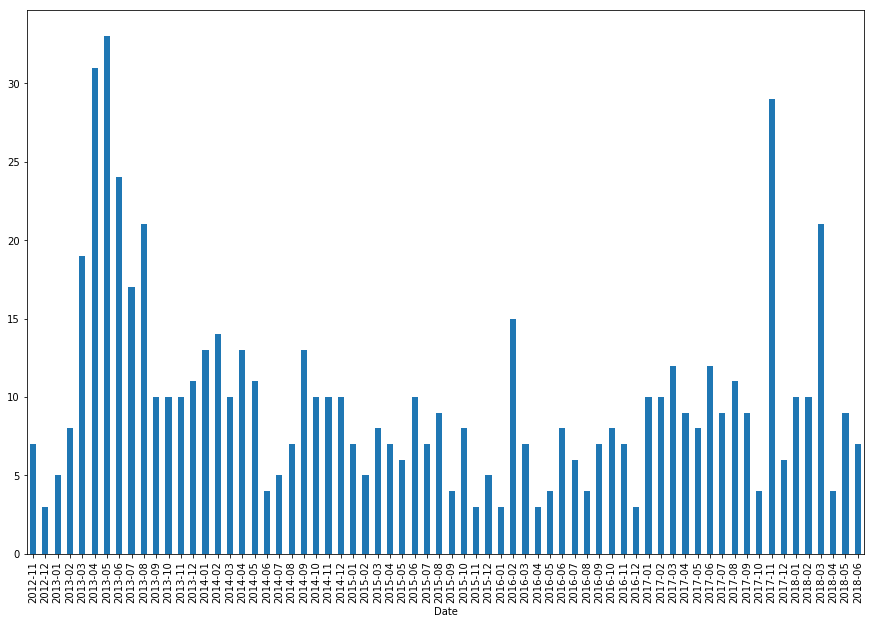

In [48]:
Analyser.plot_distribution_over_time(
    '''
    SELECT closed_at 
    FROM requests_for_permissions 
    WHERE closed_at <> '' 
    ORDER BY closed_at
    ''')

### Distribution of successful request for permission

This shows the distribution of successful request for permission over time. As time value the time when the request for permission was closed is taken.

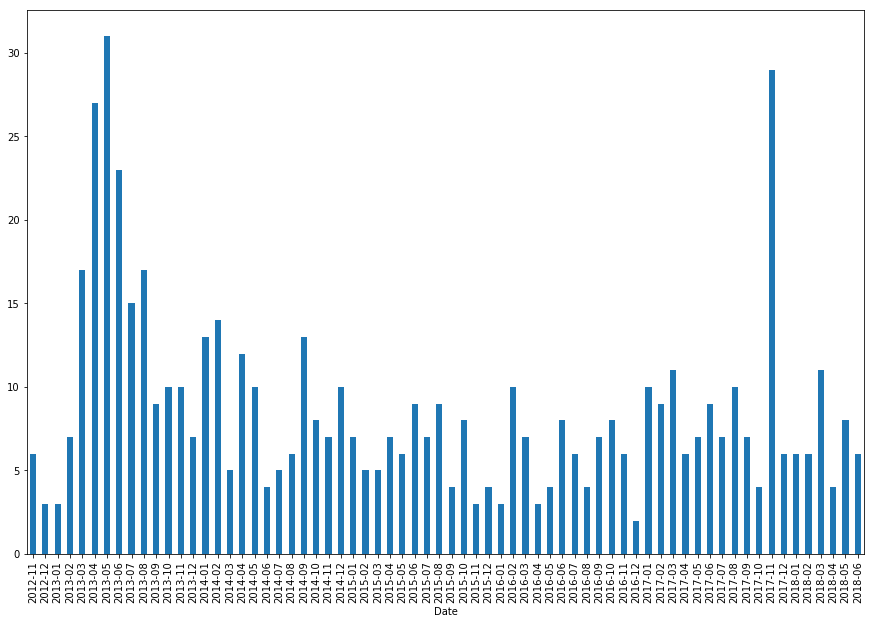

In [49]:
Analyser.plot_distribution_over_time(
    '''
    SELECT closed_at 
    FROM requests_for_permissions 
    WHERE is_successful = 1 
    AND closed_at <> '' 
    ORDER BY closed_at
    ''')

### Distribution of unsuccessful request for permission

This shows the distribution of unsuccessful request for permission over time. As time value the time when the request for permission was closed is taken.

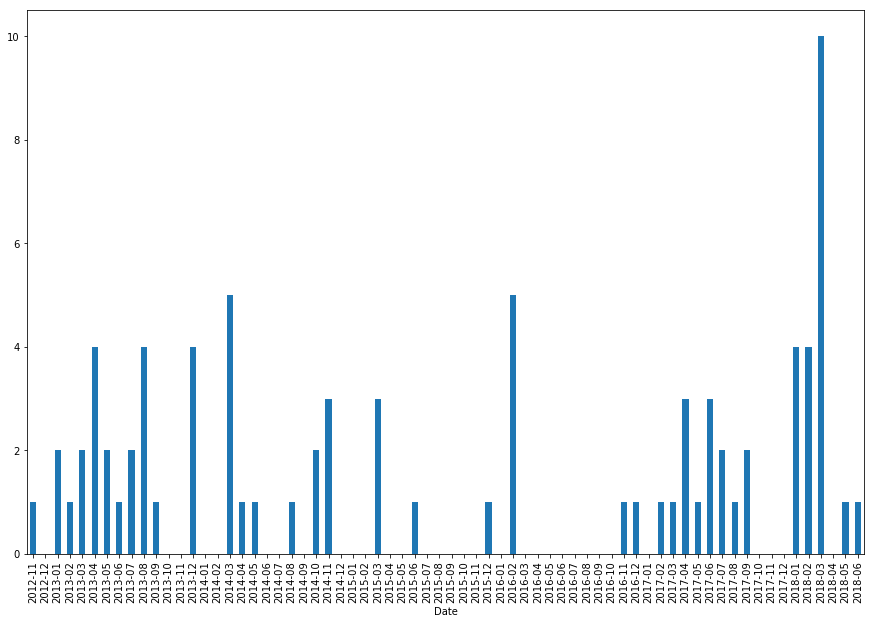

In [50]:
Analyser.plot_distribution_over_time(
    '''
    SELECT closed_at 
    FROM requests_for_permissions 
    WHERE is_successful = 0 
    AND closed_at <> '' 
    ORDER BY closed_at
    ''')

### Distribution of editor count

This shows the distribution of editor count per request for permission. The editor count represents the number of different users who edited the request for permission.

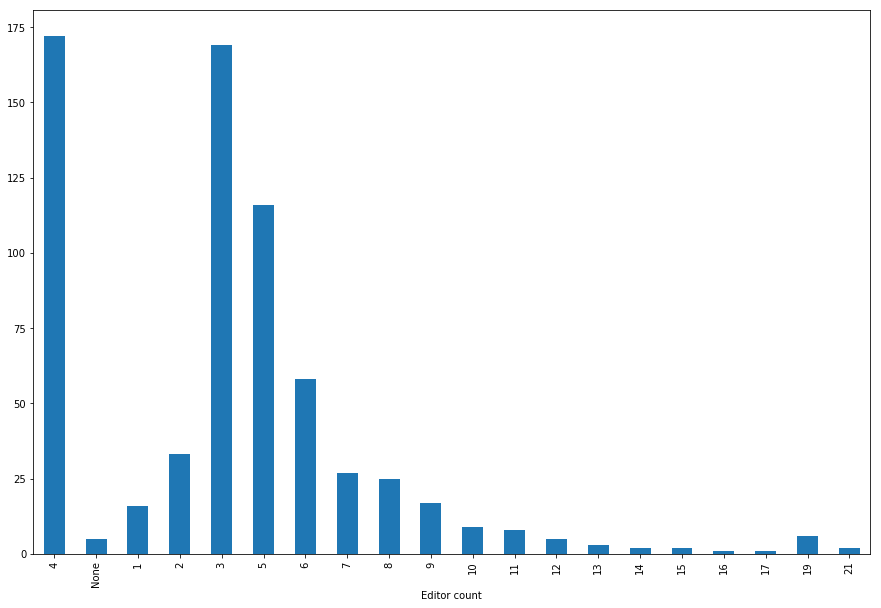

In [51]:
Analyser.plot_distribution(
    '''
    SELECT editor_count, COUNT(*)
    FROM requests_for_permissions
    GROUP BY editor_count
    ''')